In [186]:
import numpy as np
import pandas as pd
import pyreadr 
import networkx as nx
import re
from scipy import sparse
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random, jit, vmap, pmap
from itertools import combinations
import importlib
import pyro
import torch
from tqdm import tqdm

# Autoreload magic commands
%load_ext autoreload
%autoreload 2

import src.Aux_functions as aux
import models_for_data_analysis as models
import util_functions as util

importlib.reload(aux)
importlib.reload(util)
importlib.reload(models_for_data_analysis)

from models_for_data_analysis import noisy_networks_model


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


NameError: name 'models_for_data_analysis' is not defined

In [3]:
# Load data
all_schools = pyreadr.read_r('37070-0001-Data.rda')
all_schools = pd.DataFrame(all_schools['da37070.0001'])
all_schools

,SCHID,UID,SCHTREAT,SCHRB,ID,TREAT,STRB,SID1,SID3,SID4,...,AM_F,PI_M,PI_F,MU_M,MU_F,ROW_TOTAL,FREE_LUNCH,REDUCED_LUNCH,LEP,MIGRANT
0,1.0,100001.0,(1) Treatment school (Roots meetings 2012-2013),3,1,(0) Not treatment or control,0.0,5114,5114,5114,...,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(029) 281-290,(008) 71-80,(005) 41-50,(001) 0-10,[MASKED BY ICPSR]
1,1.0,100002.0,(1) Treatment school (Roots meetings 2012-2013),3,2,(2) Control,4.0,5108,5108,5108,...,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(029) 281-290,(008) 71-80,(005) 41-50,(001) 0-10,[MASKED BY ICPSR]
2,1.0,100003.0,(1) Treatment school (Roots meetings 2012-2013),3,3,(0) Not treatment or control,0.0,5100,5100,5100,...,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(029) 281-290,(008) 71-80,(005) 41-50,(001) 0-10,[MASKED BY ICPSR]
3,1.0,100004.0,(1) Treatment school (Roots meetings 2012-2013),3,4,(0) Not treatment or control,0.0,5101,5101,5101,...,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(029) 281-290,(008) 71-80,(005) 41-50,(001) 0-10,[MASKED BY ICPSR]
4,1.0,100005.0,(1) Treatment school (Roots meetings 2012-2013),3,5,(0) Not treatment or control,0.0,5087,5087,5087,...,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(029) 281-290,(008) 71-80,(005) 41-50,(001) 0-10,[MASKED BY ICPSR]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24466,60.0,6000670.0,(1) Treatment school (Roots meetings 2012-2013),11,670,NaN,NaN,13897,13897,13897,...,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(071) 701-710,(004) 31-40,(002) 11-20,(001) 0-10,[MASKED BY ICPSR]
24467,60.0,6000671.0,(1) Treatment school (Roots meetings 2012-2013),11,671,NaN,NaN,14054,14054,14054,...,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(071) 701-710,(004) 31-40,(002) 11-20,(001) 0-10,[MASKED BY ICPSR]
24468,60.0,6000672.0,(1) Treatment school (Roots meetings 2012-2013),11,672,NaN,NaN,13985,13985,13985,...,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(071) 701-710,(004) 31-40,(002) 11-20,(001) 0-10,[MASKED BY ICPSR]
24469,60.0,6000673.0,(1) Treatment school (Roots meetings 2012-2013),11,673,NaN,NaN,,,,...,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(071) 701-710,(004) 31-40,(002) 11-20,(001) 0-10,[MASKED BY ICPSR]


In [4]:
# Clean data
# Remove all observations for which both the school-id and the block-number of the school are unknown (1.14% of the observations, or 280 observations)
all_schools['ID'] = pd.to_numeric(all_schools['ID'], errors='coerce').fillna(0.0)
all_schools['SCHRB'] = pd.to_numeric(all_schools['SCHRB'], errors='coerce')
# all_schools = all_schools[~all_schools['SCHRB'].isna() & (all_schools['ID'] != 999.0)]
all_schools = all_schools[~all_schools['SCHRB'].isna() &
                          (all_schools['ID'] != 999.0) & 
                          (all_schools['ID'] != 0.0) &
                          (all_schools['UID'] != 100284.0)] 

# Create unique id
all_schools['unique_id'] = all_schools['SCHID']*1000 + all_schools['ID']
all_schools['unique_id'] = all_schools['unique_id'].astype(int)

# Convert treatment variables to numeric
def extract_numeric(x):
    match = re.search(r'\(?([0-9,.]+)\)?', str(x))
    return float(match.group(1)) if match else np.nan

all_schools['TREAT_NUMERIC'] = all_schools['TREAT'].apply(extract_numeric).fillna(0.0).astype(int)
all_schools['SCHTREAT_NUMERIC'] = all_schools['SCHTREAT'].apply(extract_numeric).fillna(0.0).astype(int)
# 
# # Create indicator of eligible units
all_schools['ELIGIBLE'] = (all_schools['TREAT_NUMERIC'] != 0.0).fillna(0.0).astype(int)
# all_schools['ELIGIBLE'] = all_schools['ELIGIBLE'].fillna(0)
# 
# # Numeric version of OUTOFBLOCK
all_schools['OUTOFBLOCK_NUMERIC'] = all_schools['OUTOFBLOCK'].apply(extract_numeric).fillna(0.0).astype(int)
# 
# # Get numeric version of outcome (wearing orange band)
all_schools['WRISTOW2_NUMERIC'] = all_schools['WRISTOW2'].apply(extract_numeric).fillna(0.0).astype(int)

N_all = all_schools.shape[0]
N_elig = all_schools['ELIGIBLE'].sum()
print("N subject:" , N_all,
      "N eligible:", N_elig)

N subject: 24182 N eligible: 2943


C:\Users\bar21\AppData\Local\Temp\ipykernel_9384\1760337585.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_schools['unique_id'] = all_schools['SCHID']*1000 + all_schools['ID']
C:\Users\bar21\AppData\Local\Temp\ipykernel_9384\1760337585.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_schools['unique_id'] = all_schools['unique_id'].astype(int)
C:\Users\bar21\AppData\Local\Temp\ipykernel_9384\1760337585.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [102]:
# Get subset of 'all_schools' with relevant columns for analysis (outcome, treatents, covariates)
df_subset = all_schools[['SCHID', 'SCHTREAT_NUMERIC', 'TREAT_NUMERIC', 'unique_id', 'ELIGIBLE', 'WRISTOW2_NUMERIC']]
# cov_list = ["GENC", "GRC", "ETHW", "ETHB", "ETHH", "ETHA", "ETHC", "ETHSA","MOVE", "FSCH","LIVEWB", "ACTSS", "ACTT", "ACTM", "ACTR","GAME", "FLIB"]
# cov_list = ["GENC", "GRC", "ETHW", "ETHB", "ETHH", "ETHA", "ETHC", "ETHSA", "MOVE", "ACTSS", "ACTT", "ACTM", "ACTR", "FLIB", "GAME"]
cov_list = ["GENC", "GRC", "ETHW", "ETHB", "ETHH", "ETHA", "ETHC", "ETHSA", "ACTSS", "ACTT", "ACTM", "ACTR", "GAME"]
# cov_list = ["GENC", "GRC", "ETHW", "ETHB", "ETHH", "ETHA", "ETHC", "ETHSA", "MOVE"]
for cov in cov_list:
    if type(all_schools[cov].iloc[1])==str:
        val = all_schools[cov].apply(extract_numeric).fillna(0.0).astype(int)
        # df_subset.loc[:,cov] = val
        df_subset = df_subset.assign(**{cov: val})
    else:
        # df_subset.loc[:,cov] = all_schools[cov]
        df_subset = df_subset.assign(**{cov: all_schools[cov]})
        
# Get dummies of 'GRC' (grade) variable
GRC_dummy = pd.get_dummies(df_subset['GRC'], drop_first=True).astype(int)
GRC_dummy.columns = ['GRC_' + str(col) for col in [6,7,8]]
df_subset = pd.concat([df_subset.drop(columns=['GRC']), GRC_dummy], axis=1)
df_subset.describe()

,SCHID,SCHTREAT_NUMERIC,TREAT_NUMERIC,unique_id,ELIGIBLE,WRISTOW2_NUMERIC,GENC,ETHW,ETHB,ETHH,...,ETHC,ETHSA,ACTSS,ACTT,ACTM,ACTR,GAME,GRC_6,GRC_7,GRC_8
count,24182.000000,24182.000000,24182.000000,24182.000000,24182.000000,24182.000000,24182.000000,24182.000000,24182.000000,24182.000000,...,24182.000000,24182.000000,24182.000000,24182.00000,24182.000000,24182.000000,24182.000000,24182.000000,24182.000000,24182.000000
mean,30.982260,0.493425,0.182532,31247.468448,0.121702,0.076338,0.508560,0.587710,0.084857,0.177984,...,0.017410,0.011000,0.330122,0.10086,0.331404,0.312340,0.643619,0.255934,0.321934,0.340749
std,16.909763,0.499967,0.520467,16920.280101,0.326948,0.265543,0.499937,0.492257,0.278674,0.382507,...,0.130795,0.104304,0.470266,0.30115,0.470728,0.463457,0.478939,0.436394,0.467227,0.473971
min,1.000000,0.000000,0.000000,1001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,19005.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30.000000,0.000000,0.000000,30208.500000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,45.000000,1.000000,0.000000,45207.750000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,60.000000,1.000000,2.000000,60674.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [103]:
pd.crosstab(df_subset["TREAT_NUMERIC"], df_subset["ELIGIBLE"])

ELIGIBLE,0,1
TREAT_NUMERIC,,
0,21239,0
1,0,1472
2,0,1471


In [104]:
all_schools['SCHID'].value_counts().describe()

count     56.000000
mean     431.821429
std      196.378679
min      115.000000
25%      283.250000
50%      417.500000
75%      563.250000
max      847.000000
Name: count, dtype: float64

In [105]:
all_schools[all_schools['SCHTREAT_NUMERIC']==0.0].groupby('SCHID')['TREAT_NUMERIC'].value_counts()
# all_schools[all_schools['SCHTREAT_NUMERIC']==1.0].groupby('SCHID')['WRISTOW2_NUMERIC'].value_counts()

SCHID  TREAT_NUMERIC
2.0    0                468
       1                 28
       2                 28
5.0    0                 75
       1                 20
                       ... 
57.0   1                 24
       2                 24
59.0   0                515
       1                 32
       2                 32
Name: count, Length: 84, dtype: int64

In [106]:
school_treat = all_schools[['SCHID', 'SCHTREAT_NUMERIC']].groupby('SCHID').agg({'SCHTREAT_NUMERIC': ['mean', 'count']}).reset_index()
school_treat

SCHID SCHTREAT_NUMERIC      
                     mean count
0    1.0              1.0   272
1    2.0              0.0   524
2    3.0              1.0   138
3    5.0              0.0   115
4    6.0              1.0   464
5    7.0              0.0   619
6    8.0              0.0   630
7    9.0              1.0   393
8   10.0              1.0   319
9   11.0              0.0   485
10  12.0              0.0   558
11  13.0              1.0   288
12  14.0              0.0   210
13  16.0              0.0   240
14  17.0              0.0   343
15  18.0              0.0   443
16  19.0              1.0   502
17  20.0              1.0   586
18  21.0              1.0   436
19  22.0              1.0   683
20  23.0              0.0   811
21  24.0              1.0   835
22  25.0              0.0   837
23  26.0              1.0   203
24  27.0              1.0   285
25  28.0              0.0   387
26  29.0              1.0   285
27  30.0              0.0   555
28  31.0              1.0   387
29  32.0              0.0   404
30  33.0              1.0   382
31  34.0              1.0   555
32  35.0              1.0   370
33  36.0              0.0   601
34  37.0              0.0   170
35  38.0              0.0   691
36  39.0              0.0   445
37  40.0              1.0   159
38  41.0              0.0   503
39  42.0              1.0   439
40  43.0              0.0   116
41  44.0              1.0   271
42  45.0              1.0   426
43  46.0              0.0   149
44  47.0              0.0   300
45  48.0              1.0   316
46  49.0              1.0   409
47  50.0              0.0   177
48  51.0              1.0   547
49  53.0              0.0   847
50  55.0              0.0   233
51  56.0              1.0   708
52  57.0              0.0   278
53  58.0              1.0   613
54  59.0              0.0   579
55  60.0              1.0   661

In [107]:
def network_by_school(df: np.ndarray, school_id: float | int , cols: list[str]) -> np.ndarray:
    # Save subset of df
    # school_df = df[df['SCHID'] == school_id]
    school_mask = df['SCHID'] == school_id
    school_df = df[school_mask].copy()  # Create a copy to avoid warnings
    school_df['unique_id'] = (school_df['SCHID']*1000 + school_df['ID']).astype(int)
    # school_df['unique_id'] = school_df['unique_id'].astype(int)
    # Replace 999 with NaN as 999 is the code for missing values
    for col in cols:
        row_mask = school_df[col] == 999
        # school_df[col][row_mask] = np.nan
        school_df.loc[row_mask,col] = np.nan
        # school_df[col][school_df[col] == 999] = np.nan
    # Add SCHID * 1000 to survey data (to obtain edge list with `unique_id` values)  
    for col in cols:
        school_df[col] += school_df['SCHID'] * 1000
    # Save edgelists
    school_edgelist = []
    for col in cols:
        school_edgelist.extend(zip(school_df['unique_id'], school_df[col]))
        
    valid_ids = set(school_df['unique_id'])
    school_edgelist = [
        (int(a), int(b)) 
        for a, b in school_edgelist 
        if not np.isnan(a) and not np.isnan(b) 
        and int(a) in valid_ids and int(b) in valid_ids
        and int(a) != int(b)
    ]
    # Add selfloops
    for id in valid_ids:
        school_edgelist.append((id, id))
    # Convert to nx graph
    school_network = nx.Graph(school_edgelist)
    # remove self loops
    school_network.remove_edges_from(nx.selfloop_edges(school_network))
    
    nx.draw_circular(school_network, 
            node_color = school_df['TREAT_NUMERIC'],
            node_size=[school_network.degree(node) + 1 for node in school_network.nodes()],
            width=0.15)

    
    # return adj. matrix
    return nx.to_numpy_array(school_network)


(272, 272) 272 <class 'numpy.ndarray'>
(272, 272) 272 <class 'numpy.ndarray'>
(272, 272) 272 <class 'numpy.ndarray'>
0.050501224 0.0 0.16177575 0.045587312
(272,) 0.073529415
(272,) 0.073529415
Zeigen: 0.068266615 0.0 0.33789584 0.042258028
Zegien / sum_eigcen: 0.034116834 0.0 0.154713 0.027852315
0.9117647 0.0 4.0 1.0 0.9469036
0.88235295 0.0 4.0 1.0 0.9358766


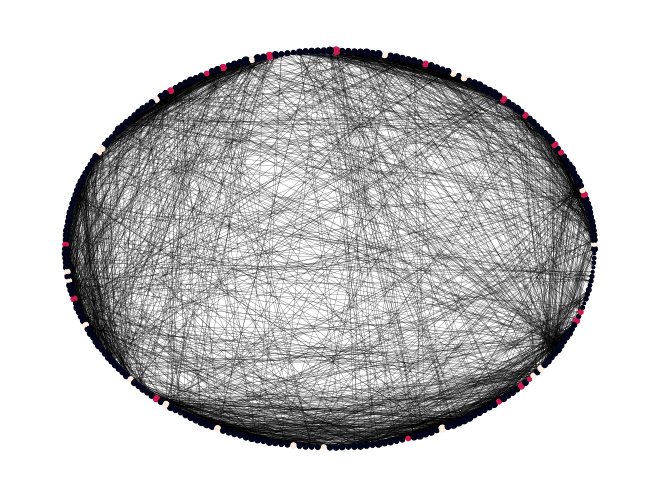

In [176]:
ST_cols = ['ST1', 'ST2', 'ST3', 'ST4', 'ST5', 'ST6', 'ST7', 'ST8', 'ST9', 'ST10']
ST_W2_cols = ['ST1W2', 'ST2W2', 'ST3W2', 'ST4W2', 'ST5W2', 'ST6W2', 'ST7W2', 'ST8W2', 'ST9W2', 'ST10W2']
BF_cols = ['BF1', 'BF2']
tst_net = network_by_school(all_schools, school_treat.iloc[0,0], ST_cols)
tst_new_W2 = network_by_school(all_schools, school_treat.iloc[0,0], ST_W2_cols)
tst_new_BF = network_by_school(all_schools, school_treat.iloc[0,0], BF_cols)

print(tst_net.shape, school_treat.iloc[0,2], type(tst_net))
print(tst_new_W2.shape, school_treat.iloc[0,2], type(tst_new_W2))
print(tst_new_BF.shape, school_treat.iloc[0,2], type(tst_new_BF))
eig_cen = aux.eigen_centrality(tst_net)
print(np.mean(eig_cen), np.min(eig_cen), np.max(eig_cen), np.median(eig_cen))

trts = jnp.array((all_schools[all_schools['SCHID'] == school_treat.iloc[0,0]]['TREAT_NUMERIC']==1).astype(int))
cntrl = jnp.array((all_schools[all_schools['SCHID'] == school_treat.iloc[0,0]]['TREAT_NUMERIC']==2).astype(int))
print(trts.shape, trts.mean())
print(cntrl.shape, cntrl.mean())
zeigen = aux.zeigen_value(trts, eig_cen , tst_net)
print("Zeigen:", np.mean(zeigen), np.min(zeigen), np.max(zeigen), np.median(zeigen))
zeigen_standratized = (aux.zeigen_value(trts, eig_cen , tst_net)) / (jnp.dot(tst_net, eig_cen)+1)
print("Zegien / sum_eigcen:", np.mean(zeigen_standratized), np.min(zeigen_standratized), np.max(zeigen_standratized), np.median(zeigen_standratized))
n_trts = jnp.dot(tst_net, trts) 
print(np.mean(n_trts), np.min(n_trts), np.max(n_trts), np.median(n_trts), np.std(n_trts))
n_cntrl = jnp.dot(tst_net, cntrl)
print(np.mean(n_cntrl), np.min(n_cntrl), np.max(n_cntrl), np.median(n_cntrl), np.std(n_cntrl))
# plt.hist(np.sum(tst_net, 1), bins=30)

0.5808824 0.5919118 0.80514705


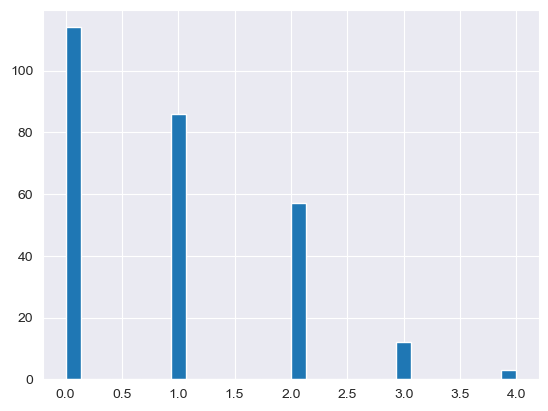

In [109]:
plt.hist(n_trts , bins=30)
print(np.mean(n_trts>0), np.mean(n_cntrl>0), np.mean(((n_trts > 0) | (n_cntrl > 0))))
# plt.scatter(zeigen, np.dot(tst_net, trts), c=trts)
# plt.scatter(n_trts[n_trts>0], zeigen_standratized[n_trts>0], c=trts[n_trts>0])
# plt.scatter(zeigen, zeigen_standratized, c=trts)

In [110]:
tab_df = pd.DataFrame({'n_trt': n_trts>0, 'zeig': zeigen >0})
pd.crosstab(tab_df['n_trt'], tab_df['zeig'])

zeig,False,True
n_trt,,
False,114,0
True,0,158


In [133]:
# Get df for network analysis
# generate covariates as indicator of equality in unit-level covariates: X_ij = I(X_i = X_j)

school_mask = df_subset['SCHID'] == school_treat.iloc[0,0]
school_df = df_subset[school_mask].copy()  # Create a copy to avoid warnings

idx_pairs = list(combinations(range(school_df.shape[0]), 2))

def cov_equal(X: pd.DataFrame, idx_pairs: list) -> list[int]:
    return [int(np.all(X.iloc[i] == X.iloc[j])) for i, j in idx_pairs]

def create_net_covar_df(df: pd.DataFrame, cov_groups: list) -> pd.DataFrame:
    idx_pairs = list(combinations(range(df.shape[0]), 2))
    cov_eq = [cov_equal(df[cov], idx_pairs) for cov in cov_groups]
    df_network = pd.DataFrame(dict(zip(['+'.join(cov) for cov in cov_groups], cov_eq)))
   
    expected_rows = df.shape[0] * (df.shape[0] - 1) // 2
    assert df_network.shape[0] == expected_rows, f"Expected {expected_rows} rows, got {df_network.shape[0]}"
    
    return df_network
    
cov_for_network = [["GENC"],
                   ["ETHW", "ETHB", "ETHH", "ETHA", "ETHC", "ETHSA"],
                   # ["ACTSS", "ACTT", "ACTM", "ACTR"],
                   ["GAME"],
                   ["GRC_6", "GRC_7", "GRC_8"]]
# cov_eq = [cov_equal(school_df[cov], idx_pairs) for cov in cov_for_network]
# df_for_network = pd.DataFrame(cov_eq).T
# df_for_network.columns = ["GENC", "ETH", "MOVE", "FSCH", "LIVEWB", "ACT", "GAME", "FLIB", "GRC"]
df_for_network = create_net_covar_df(school_df, cov_for_network)

print(school_df.shape[0]*(school_df.shape[0]-1)/2, df_for_network.shape[0])
print(df_for_network.describe())
    

36856.0 36856
               GENC  ETHW+ETHB+ETHH+ETHA+ETHC+ETHSA          GAME  \
count  36856.000000                    36856.000000  36856.000000   
mean       0.502740                        0.312649      0.516497   
std        0.499999                        0.463579      0.499735   
min        0.000000                        0.000000      0.000000   
25%        0.000000                        0.000000      0.000000   
50%        1.000000                        0.000000      1.000000   
75%        1.000000                        1.000000      1.000000   
max        1.000000                        1.000000      1.000000   

       GRC_6+GRC_7+GRC_8  
count       36856.000000  
mean            0.333324  
std             0.471408  
min             0.000000  
25%             0.000000  
50%             0.000000  
75%             1.000000  
max             1.000000  


In [135]:
print(jnp.array(df_for_network).shape, jnp.array(df_for_network).sum(axis=1).mean())

(36856, 4) 1.6652106


In [136]:
# # adj mat to triu vals
# @jit
# def adj_to_triu(mat: np.ndarray) -> jnp.ndarray:
#     return jnp.array(mat[np.triu_indices(mat.shape[0], k=1)])

def adj_to_triu(mat: np.ndarray) -> np.ndarray:
    return mat[np.triu_indices(mat.shape[0], k=1)]

triu_sch = adj_to_triu(tst_net)
print(triu_sch.shape, triu_sch.sum(), tst_net.sum()/2, type(triu_sch))


(36856,) 1513.0 1513.0 <class 'numpy.ndarray'>


In [137]:
print(jnp.array([adj_to_triu(tst_net), adj_to_triu(tst_new_W2)]).shape)
print(jnp.array([adj_to_triu(tst_net), adj_to_triu(tst_new_W2)])[0,:].shape)
print(jnp.array([adj_to_triu(tst_net), adj_to_triu(tst_new_W2)])[1,:].shape)
print(jnp.array([adj_to_triu(tst_net), adj_to_triu(tst_new_W2)]).ndim)
print(jnp.array(adj_to_triu(tst_net)).ndim)
print(jnp.array(adj_to_triu(tst_net)).shape)

(2, 36856)
(36856,)
(36856,)
2
1
(36856,)


In [138]:
print(jnp.array(df_for_network).shape)
print(jnp.dot(jnp.array(df_for_network),jnp.ones(4)).shape)


(36856, 4)
(36856,)


In [139]:
torch.from_numpy(adj_to_triu(tst_net)).shape

torch.Size([36856])

In [140]:
torch.tensor(np.array(df_for_network)).shape[1]


4

In [177]:
tst_ST_triu = torch.tensor(adj_to_triu(tst_net),dtype=torch.float32)
tst_STW2_triu = torch.tensor(adj_to_triu(tst_new_W2),dtype=torch.float32)
tst_BF_triu = torch.tensor(adj_to_triu(tst_new_BF),dtype=torch.float32)

In [187]:
rng_key = random.PRNGKey(1)
rng_key, rng_key_ = random.split(rng_key)

school_svi_tst = util.Network_SVI(x_df = torch.tensor(np.array(df_for_network), dtype=torch.float32), 
                                  # triu_obs = torch.tensor(adj_to_triu(tst_net),dtype=torch.float32))
                                  # triu_obs = torch.stack([tst_ST_triu, tst_STW2_triu]),
                                  triu_obs = torch.stack([tst_ST_triu, tst_BF_triu]),
                                  network_model=models.multilayer_networks_model)
                                  # network_model=models.repeated_noisy_networks_model)

school_svi_tst.train_model()

Training network model: 100%|██████████| 15000/15000 [10:51<00:00, 23.02it/s]


In [188]:
school_posterior_samps_svi = school_svi_tst.network_samples()

Sampling A*: 100%|██████████| 10000/10000 [05:58<00:00, 27.90it/s]


In [189]:
school_posterior_samps_svi.shape

(10000, 36856)

In [190]:
school_triu_obs_pred = school_svi_tst.sample_triu_obs_predictive(num_samples = 10000)
school_triu_obs_pred.shape

dict_keys(['nu', 'theta_intercept', 'theta', 'gamma_1', 'gamma_2', 'triu_star', 'obs_triu_A1', 'obs_triu_A2'])


torch.Size([2, 10000, 36856])

In [192]:
school_triu_obs_pred[0,0].shape

torch.Size([36856])

In [145]:
school_triu_obs_pred.std(axis=0)

tensor([0.4615, 0.4226, 0.4045,  ..., 0.0662, 0.3466, 0.0684])

In [193]:
def triu_to_mat(triu_values, N):
    """
    Convert upper triangular values to a full adjacency matrix.
    
    Parameters:
    triu_values (torch.Tensor): Upper triangular values, shape (num_triu_elements,)
    N (int): Number of nodes in the network
    
    Returns:
    torch.Tensor: Full adjacency matrix, shape (N, N)
    """
    # Create an empty N x N matrix
    adj_matrix = torch.zeros((N, N), dtype=triu_values.dtype)
    
    # Get the indices for the upper triangular part
    triu_indices = torch.triu_indices(N, N, offset=1)
    
    # Fill the upper triangular part
    adj_matrix[triu_indices[0], triu_indices[1]] = triu_values
    
    # Make the matrix symmetric by adding its transpose
    adj_matrix = adj_matrix + adj_matrix.T
    
    return adj_matrix

N_units = school_df.shape[0]

degs_post = torch.zeros(N_units, dtype=school_triu_obs_pred.dtype)
degs_post2 = torch.zeros(N_units, dtype=school_triu_obs_pred.dtype)
deg_post_star = torch.zeros(N_units, dtype=school_triu_obs_pred.dtype)

for i in tqdm(range(10000)):
    mat_i = triu_to_mat(school_triu_obs_pred[0,i], N_units)
    mat_i2 = triu_to_mat(school_triu_obs_pred[1,i], N_units)
    cur_deg = mat_i.sum(axis=1)
    cur_deg2 = mat_i2.sum(axis=1)
    degs_post += cur_deg
    degs_post2 += cur_deg2
    star_mat_i = triu_to_mat(torch.from_numpy(np.array(school_posterior_samps_svi[i])), N_units)
    deg_post_star += star_mat_i.sum(axis=1)

degs_post /= 10000
degs_post2 /= 10000
deg_post_star /= 10000

# obs_deg = torch.tensor((tst_new_W2.sum(axis=1) + tst_net.sum(axis=1))/2, dtype=deg_post_star.dtype)
obs_deg = torch.tensor(tst_net.sum(axis=1), dtype=deg_post_star.dtype)
obs_deg2 = torch.tensor(tst_new_BF.sum(axis=1), dtype=deg_post_star.dtype)

# print("MAE:", torch.mean(torch.abs((obs_deg - degs_post))))

# plt.figure(figsize=(4,3))
# plt.scatter(obs_deg, degs_post)
# x axis label = "Observed degree"
# y axis label = "Posterior predictive degree"
# plt.xlabel("Observed degree")
# plt.ylabel("Posterior predictive degree")
# plt.axline((0, 0), slope=1, color="orange", linestyle="--")   
    

100%|██████████| 10000/10000 [00:25<00:00, 391.80it/s]


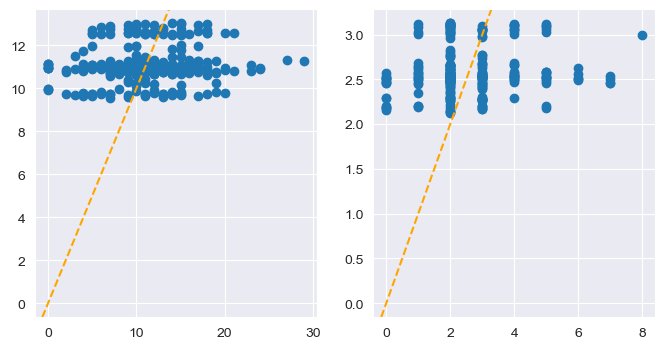

In [194]:
# plt.figure(figsize=(4,3))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# plt.scatter(obs_deg, deg_post_star)
ax1.scatter(obs_deg, degs_post)
ax1.axline((0, 0), slope=1, color="orange", linestyle="--")
ax2.scatter(obs_deg2, degs_post2)
ax2.axline((0, 0), slope=1, color="orange", linestyle="--")
# x axis label = "Observed degree"
# y axis label = "Posterior predictive degree"
# plt.xlabel("Observed degree")
# plt.ylabel("Posterior star degree")
# plt.axline((0, 0), slope=1, color="orange", linestyle="--")  

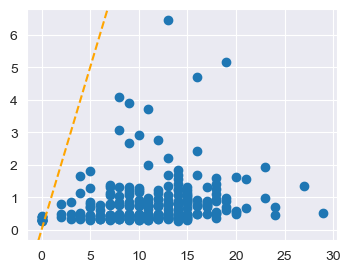

In [195]:
plt.figure(figsize=(4,3))
plt.scatter(obs_deg, deg_post_star)
plt.axline((0, 0), slope=1, color="orange", linestyle="--")

In [ ]:
# TODO: create numpyro network models, e.g.:
# 1. ST is an a errorenously measured network
# 2. ST + BF multilayer network (true is latent)
# 3. ST + STW2 repeated noisy measurements
# in all networks can be modeled with LSM where the latent locations will be included in the outcome model as well
# for each school we need to generate M posterior samples of A* 


In [ ]:
# TODO: model each school network seperately (can be same model with different parameters)
# TODO: Think how to model the outcome model (what structrual assumptions) and what are the relevant causal estimands
# TODO: Think the outcome analysis should be limited to the eligible students only (due to positivity)
# TODO: write wrapper function that generate triu_star samples for each school network for each network model
# TODO: write a function that takes the school networks (observed, multistage, or onestage) and run outcome regression and get predictions for estimand
# TODO: think about estimands. Good options is to take stochastic estimands with different alphas (e.g., alpha = 0.3,0.5,0.7)
# Nonetheless, the network analysis should be done on the full network of each school (avoid network sampling)
